In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import json
import matplotlib
import os
import random
import torch

from collections import Counter
from itertools import islice
from sklearn.utils import shuffle
from tqdm import tqdm, trange
from torch.optim import Adam
from torch.utils.data import TensorDataset

from models.Encoder import *
from models.Decoder import *
from models.utils import *
from utils import *

# set fixed random seed to reproduce results
np.random.seed(42)
random.seed(42)

%matplotlib inline

# Experiment 1b

In [2]:
# define experiment
exp='/exp_1'
# define number of iterations
n_iters = 100000

In [3]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# load dataset into memory, and get w2idx, idx2w, w2freq dictionaries and lists of input and output sentences
cmd_vocab, w2i_cmds, i2w_cmds, cmds_train, act_vocab, w2i_acts, i2w_acts, acts_train = load_dataset(exp=exp, split='/train')
_, _, _, cmds_test, _, _, _, acts_test = load_dataset(exp=exp, split='/test')

In [5]:
## create input and output language pairs ##

# training
train_cmd_act_pairs = create_pairs(cmds_train, acts_train)
print("Number of train source-target pairs: {}".format(len(train_cmd_act_pairs)))

# testing
test_cmd_act_pairs = create_pairs(cmds_test, acts_test)
print("Number of test source-target pairs: {}".format(len(test_cmd_act_pairs)))

Number of train source-target pairs: 16728
Number of test source-target pairs: 4182


In [6]:
# show random train command-action pair
random_pair = random.choice(train_cmd_act_pairs)
print("Command: {}".format(random_pair[0]))
print("Action: {}".format(random_pair[1]))

Command: ['look', 'left', 'thrice', 'after', 'turn', 'opposite', 'left']
Action: ['I_TURN_LEFT', 'I_TURN_LEFT', 'I_TURN_LEFT', 'I_LOOK', 'I_TURN_LEFT', 'I_LOOK', 'I_TURN_LEFT', 'I_LOOK']


In [7]:
# show random test command-action pair
random_pair = random.choice(test_cmd_act_pairs)
print("Command: {}".format(random_pair[0]))
print("Action: {}".format(random_pair[1]))

Command: ['run', 'right', 'thrice', 'after', 'jump', 'right']
Action: ['I_TURN_RIGHT', 'I_JUMP', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN']


In [8]:
cmds_train, acts_train = pairs2idx(cmds_train, acts_train, w2i_cmds, w2i_acts)
cmds_test, acts_test = pairs2idx(cmds_test, acts_test, w2i_cmds, w2i_acts)

In [16]:
# create train and test data loaders
train_dl = create_batches(cmds_train, acts_train, batch_size=32, split='train', num_samples=n_iters)
test_dl = create_batches(cmds_test, acts_test, batch_size=32, split='test')

In [9]:
## Hyperparameters for training ##

# source language (i.e., commands) vocabulary size |V_source|
in_size = len(w2i_cmds)

# target language (i.e., actions) vocabulary size |V_target|
out_size = len(w2i_acts)

# size of word embeddings
emb_size = 20

# size of hidden units
hidden_size = 100

# number of layers
n_layers = 2

# number of epochs
n_epochs = 2 # 2-4 epochs (100.000 iterations each) seem to be sufficient to learn the mapping

In [10]:
## Instantiate models ##

encoder = EncoderLSTM(in_size, emb_size, hidden_size, n_layers)
decoder = DecoderLSTM(emb_size, hidden_size, out_size, n_layers)

In [11]:
# move models to GPU, if GPU is available (for faster computation)
encoder.cuda()
decoder.cuda()

DecoderLSTM(
  (embedding): Embedding(10, 20)
  (lstm): LSTM(20, 50, num_layers=2, dropout=0.5)
  (linear): Linear(in_features=50, out_features=10, bias=True)
)

## Training (1a)

In [12]:
# train_losses, train_accs, encoder, decoder = train(train_cmd_act_pairs, w2i_cmds, w2i_acts, i2w_cmds, i2w_acts, encoder, decoder, n_epochs)

## Testing (1a)

In [13]:
# test_acc = test(test_cmd_act_pairs, w2i_cmds, w2i_acts, i2w_cmds, i2w_acts, encoder, decoder)

## Train and test over different numbers of distinct source-target pairs (1b)

In [14]:
## experiment 1b train and test loop over pre-defined ratios ##

ratios = np.array([0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64])
accs_per_ratio = {}

for ratio in ratios:
    train_samples = sample_distinct_pairs(train_cmd_act_pairs, ratio)
    print("-------------------------------------------------")
    print("Current percentage of total commands used for training: {}%".format(ratio*100))
    print("Number of distinct examples shown during training: {}".format(len(train_samples)))
    print("-------------------------------------------------")
    # instantiate new encoder and decoder for each ratio
    encoder = EncoderLSTM(in_size, emb_size, hidden_size, n_layers)
    decoder = DecoderLSTM(emb_size, hidden_size, out_size, n_layers)
    encoder.cuda()
    decoder.cuda()
    g
    train_losses, train_accs, encoder, decoder = train(train_samples, w2i_cmds, w2i_acts, i2w_cmds, i2w_acts, encoder, decoder, n_epochs)
    test_acc = test(test_cmd_act_pairs, w2i_cmds, w2i_acts, i2w_cmds, i2w_acts, encoder, decoder)
    accs_per_ratio[ratio] = test_acc

-------------------------------------------------
Current percentage of total commands used for training: 1.0%
Number of distinct examples shown during training: 167


Epoch:   0%|                                                                                     | 0/2 [00:00<?, ?it/s]

Loss: 0.24522526264190675
Acc: 0.0837916208379162

Command: walk left thrice after jump left <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT

True sent length: 9
Pred sent length: 9

Loss: 0.0691698881296011
Acc: 0.28583570821458926

Command: run opposite right thrice and walk twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_WALK I_WALK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_WALK I_WALK <EOS>

True sent length: 12
Pred sent length: 12

Loss: 0.039535204569498696
Acc: 0.4392853571547615

Command: jump right twice and walk opposite left twice <EOS>
True action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_

Epoch:  50%|███████████████████████████████████▌                                   | 1/2 [1:45:37<1:45:37, 6337.11s/it]

Loss: 0.00046238899230957033
Acc: 0.9365063493650635

Command: walk left thrice after jump left <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>

True sent length: 9
Pred sent length: 9

Loss: 0.0007960246159480169
Acc: 0.9452027398630068

Command: run opposite right thrice and walk twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_WALK I_WALK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_WALK I_WALK <EOS>

True sent length: 12
Pred sent length: 12

Loss: 0.0010148684183756511
Acc: 0.9492683577214093

Command: jump right twice and walk opposite left twice <EOS>
True action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_

Epoch: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [3:33:36<00:00, 6408.46s/it]


Test acc: 0.04295704295704296

Command: run around right thrice and turn around right thrice <EOS>
True action: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>

True sent length: 37
Pred sent length: 41

Test acc: 0.038980509745127435

Command: turn around le

Epoch:   0%|                                                                                     | 0/2 [00:00<?, ?it/s]

Loss: 0.1804027557373047
Acc: 0.0811918808119188

Command: walk right thrice and walk twice <EOS>
True action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_WALK I_WALK <EOS>
Pred action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <EOS>

True sent length: 9
Pred sent length: 9

Loss: 0.05508089065551758
Acc: 0.2358882055897205

Command: run left and run right twice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>

True sent length: 7
Pred sent length: 7

Loss: 0.11224066509920008
Acc: 0.3505216492783574

Command: jump around left thrice and look around left <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_LOOK I_TURN_LEF

Epoch:  50%|███████████████████████████████████▌                                   | 1/2 [1:45:08<1:45:08, 6308.03s/it]

Loss: 0.0026381492614746095
Acc: 0.8789121087891211

Command: walk right thrice and walk twice <EOS>
True action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_WALK I_WALK <EOS>
Pred action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_WALK I_WALK <EOS>

True sent length: 9
Pred sent length: 9

Loss: 0.0038605928421020508
Acc: 0.8938553072346382

Command: run left and run right twice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>

True sent length: 7
Pred sent length: 7

Loss: 0.0009091741898480584
Acc: 0.9009366354454852

Command: jump around left thrice and look around left <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_LOOK I_TURN_LE

Epoch: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [3:33:49<00:00, 6414.58s/it]


Test acc: 0.2097902097902098

Command: walk opposite left twice after walk opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>

True sent length: 16
Pred sent length: 15

Test acc: 0.20389805097451275

Command: turn right twice after turn opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>

True sent length: 9
Pred sent length: 11

Test acc: 0.20226591136287905

Command: run around right after look opposite left <EOS>
True action: I_TURN_LE

Epoch:   0%|                                                                                     | 0/2 [00:00<?, ?it/s]

Loss: 0.29207386690027576
Acc: 0.0463953604639536

Command: run opposite right thrice and run left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_TURN_RIGHT I_RUN I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>

True sent length: 16
Pred sent length: 16

Loss: 0.20264506340026855
Acc: 0.17639118044097796

Command: look right thrice and turn around left twice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT

True sent length: 15
Pred sent 

Epoch:  50%|███████████████████████████████████▌                                   | 1/2 [1:45:15<1:45:15, 6315.21s/it]

Loss: 0.0010297158185173484
Acc: 0.9083091690830917

Command: run opposite right thrice and run left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>

True sent length: 16
Pred sent length: 16

Loss: 0.0016804039478302002
Acc: 0.9136543172841358

Command: look right thrice and turn around left twice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>

True sent length: 15
Pred sent length: 1

Epoch: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [3:31:16<00:00, 6338.45s/it]


Test acc: 0.7732267732267732

Command: look right after run twice <EOS>
True action: I_RUN I_RUN I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_RUN I_RUN I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>

True sent length: 5
Pred sent length: 6

Test acc: 0.7791104447776112

Command: look left thrice and turn opposite right thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>

True sent length: 13
Pred sent length: 13

Test acc: 0.7770743085638121

Command: jump opposite right thrice and walk twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_WALK I_WALK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_WALK 

Epoch:   0%|                                                                                     | 0/2 [00:00<?, ?it/s]

Loss: 0.43540199597676593
Acc: 0.041695830416958304

Command: turn right and run thrice <EOS>
True action: I_TURN_RIGHT I_RUN I_RUN I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_RUN <EOS>

True sent length: 5
Pred sent length: 5

Loss: 0.10668783187866211
Acc: 0.1496425178741063

Command: look opposite left twice after turn opposite left <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>

True sent length: 9
Pred sent length: 9

Loss: 0.026005528189919212
Acc: 0.27305756474784176

Command: jump left thrice after turn left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>

True sent length: 10
Pred sent length: 10

Loss: 0.04304

Epoch:  50%|███████████████████████████████████▌                                   | 1/2 [1:46:36<1:46:36, 6396.37s/it]

Loss: 0.0015211105346679688
Acc: 0.9421057894210579

Command: turn right and run thrice <EOS>
True action: I_TURN_RIGHT I_RUN I_RUN I_RUN <EOS>
Pred action: I_TURN_RIGHT I_RUN I_RUN I_RUN <EOS>

True sent length: 5
Pred sent length: 5

Loss: 0.0008231163024902344
Acc: 0.9457527123643817

Command: look opposite left twice after turn opposite left <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>

True sent length: 9
Pred sent length: 9

Loss: 0.0014200210571289062
Acc: 0.949368354388187

Command: jump left thrice after turn left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>

True sent length: 10
Pred sent length: 10

Loss: 0.00086645646

Epoch: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [3:33:57<00:00, 6418.85s/it]


Test acc: 0.9400599400599401

Command: turn right thrice and walk left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>

True sent length: 10
Pred sent length: 10

Test acc: 0.9325337331334332

Command: turn right thrice after run thrice <EOS>
True action: I_RUN I_RUN I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_RUN I_RUN I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>

True sent length: 7
Pred sent length: 7

Test acc: 0.9306897700766411

Command: walk opposite left after jump left twice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_WALK <EOS>

True sent length: 8
Pred sent length: 8

Test acc: 0.9292676830792302

Command: walk after jump opposite 

Epoch:   0%|                                                                                     | 0/2 [00:00<?, ?it/s]

Loss: 0.2559029034205845
Acc: 0.030496950304969503

Command: turn left twice after jump around right thrice <EOS>
True action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT <EOS>

True sent length: 27
Pred sent length: 26

Loss: 0.09834473974564496
Acc: 0.12739363031848408

Command: jump around right twice after look around right twice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT 

Epoch:  50%|███████████████████████████████████▌                                   | 1/2 [1:44:42<1:44:42, 6282.15s/it]

Loss: 0.001250147819519043
Acc: 0.923007699230077

Command: turn left twice after jump around right thrice <EOS>
True action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_TURN_LEFT <EOS>

True sent length: 27
Pred sent length: 27

Loss: 0.015428585164687213
Acc: 0.9309034548272587

Command: jump around right twice after look around right twice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_T

Epoch: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [3:30:15<00:00, 6307.64s/it]


Test acc: 0.9500499500499501

Command: run opposite right after run opposite left <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>

True sent length: 7
Pred sent length: 7

Test acc: 0.9540229885057471

Command: look left twice and run thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_RUN I_RUN I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_RUN I_RUN I_RUN <EOS>

True sent length: 8
Pred sent length: 8

Test acc: 0.9536821059646784

Command: look right thrice after look twice <EOS>
True action: I_LOOK I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_LOOK I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK <EOS>

True sent length: 9
Pred sent length: 9

Test acc: 0.9520119970007498

Command: turn opposite left twice after walk opposite left <EOS>
True action: I_TURN_LEFT I_TURN_LEFT 

Epoch:   0%|                                                                                     | 0/2 [00:00<?, ?it/s]

Loss: 0.24876318659101213
Acc: 0.029197080291970802

Command: turn left thrice and jump opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>

True sent length: 13
Pred sent length: 13

Loss: 0.2363841732343038
Acc: 0.12769361531923404

Command: look opposite left twice after run around right twice <EOS>
True action: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_LOO

Epoch:  50%|███████████████████████████████████▌                                   | 1/2 [1:45:01<1:45:01, 6301.23s/it]

Loss: 0.001140322004045759
Acc: 0.9364063593640636

Command: turn left thrice and jump opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>

True sent length: 13
Pred sent length: 13

Loss: 0.0008449554443359375
Acc: 0.9384030798460077

Command: look opposite left twice after run around right twice <EOS>
True action: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_LEFT I_TURN_LEFT I_

Epoch: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [3:30:40<00:00, 6320.01s/it]


Test acc: 0.985014985014985

Command: look opposite right twice and walk around right <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <EOS>

True sent length: 15
Pred sent length: 15

Test acc: 0.984007996001999

Command: turn around left twice and jump opposite left <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>

True sent length: 12
Pred sent length: 12

Test acc: 0.9823392202599134

Command: turn right twice after look <EOS>
True action: I_LOOK I_TURN_RIGHT I_

Epoch:   0%|                                                                                     | 0/2 [00:00<?, ?it/s]

Loss: 0.35200977325439453
Acc: 0.0433956604339566

Command: walk thrice and jump around left <EOS>
True action: I_WALK I_WALK I_WALK I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>
Pred action: I_WALK I_WALK I_WALK I_WALK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>

True sent length: 12
Pred sent length: 12

Loss: 0.07875943183898926
Acc: 0.16024198790060498

Command: run right after run <EOS>
True action: I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred action: I_RUN I_TURN_RIGHT I_RUN <EOS>

True sent length: 4
Pred sent length: 4

Loss: 0.04616491794586182
Acc: 0.30338988700376657

Command: jump right and jump around right twice <EOS>
True action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TUR

Epoch:  50%|███████████████████████████████████▌                                   | 1/2 [2:16:20<2:16:20, 8180.92s/it]

Loss: 0.00046227528498722956
Acc: 0.9657034296570343

Command: walk thrice and jump around left <EOS>
True action: I_WALK I_WALK I_WALK I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>
Pred action: I_WALK I_WALK I_WALK I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>

True sent length: 12
Pred sent length: 12

Loss: 0.004644870758056641
Acc: 0.9689015549222539

Command: run right after run <EOS>
True action: I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred action: I_RUN I_TURN_RIGHT I_RUN <EOS>

True sent length: 4
Pred sent length: 4

Loss: 0.0010087966918945312
Acc: 0.9645011832938902

Command: jump right and jump around right twice <EOS>
True action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN

Epoch: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [4:01:55<00:00, 7257.85s/it]


Test acc: 0.993006993006993

Command: run left twice after jump right twice <EOS>
True action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>

True sent length: 9
Pred sent length: 9

Test acc: 0.9920039980009995

Command: turn around right thrice and run around right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_R

In [15]:
# save results in .json file
with open('./results/experiment_1b.json', 'w') as json_file:
      json.dump(accs_per_ratio, json_file)

In [56]:
# load results from experiment 1b
with open('./results/experiment_1b.json') as json_file:
    accs_per_ratio = json.load(json_file)

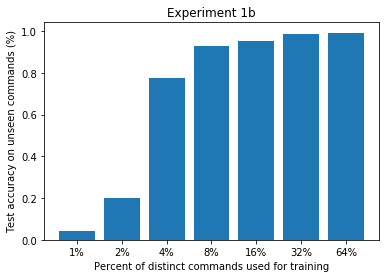

<Figure size 432x288 with 0 Axes>

In [58]:
ratios, test_accs = zip(*accs_per_ratio.items())
plt.bar(ratios, test_accs)
plt.xlabel('Percent of distinct commands used for training')
plt.ylabel('Test accuracy on unseen commands (%)')
plt.xticks(ticks=ratios, labels=list(map(lambda rat: str(int(float(rat) * 100)) + '%', ratios)))
plt.title('Experiment 1b')
plt.savefig('./Paper/Plots/experiment_1b.png')
plt.show()
plt.clf()